Epoch [10/100], Training Loss: 0.5286, Validation Loss: 0.5051
Epoch [20/100], Training Loss: 0.3168, Validation Loss: 0.2874
Epoch [30/100], Training Loss: 0.1395, Validation Loss: 0.1142
Epoch [40/100], Training Loss: 0.0530, Validation Loss: 0.0379
Epoch [50/100], Training Loss: 0.0220, Validation Loss: 0.0143
Epoch [60/100], Training Loss: 0.0134, Validation Loss: 0.0070
Epoch [70/100], Training Loss: 0.0104, Validation Loss: 0.0043
Epoch [80/100], Training Loss: 0.0069, Validation Loss: 0.0030
Epoch [90/100], Training Loss: 0.0063, Validation Loss: 0.0023
Epoch [100/100], Training Loss: 0.0057, Validation Loss: 0.0019

Model trained and saved as 'mlp_model.pth'.


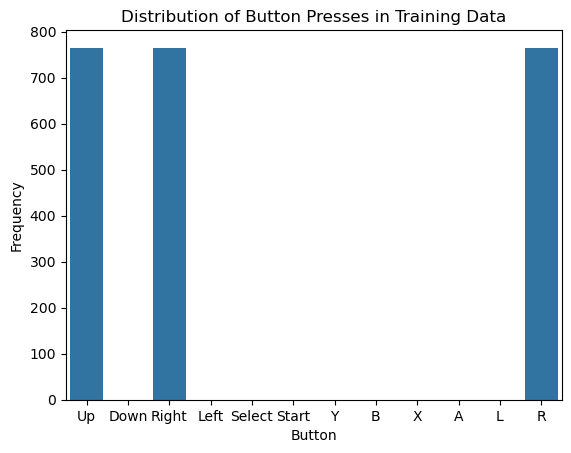

Classification Report:
              precision    recall  f1-score   support

          Up       1.00      1.00      1.00       192
        Down       0.00      0.00      0.00         0
       Right       1.00      1.00      1.00       192
        Left       0.00      0.00      0.00         0
      Select       0.00      0.00      0.00         0
       Start       0.00      0.00      0.00         0
           Y       0.00      0.00      0.00         0
           B       0.00      0.00      0.00         0
           X       0.00      0.00      0.00         0
           A       0.00      0.00      0.00         0
           L       0.00      0.00      0.00         0
           R       1.00      1.00      1.00       192

   micro avg       1.00      1.00      1.00       576
   macro avg       0.25      0.25      0.25       576
weighted avg       1.00      1.00      1.00       576
 samples avg       1.00      1.00      1.00       576


Model Accuracy (Mean Label-wise Accuracy per Sample): 1

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


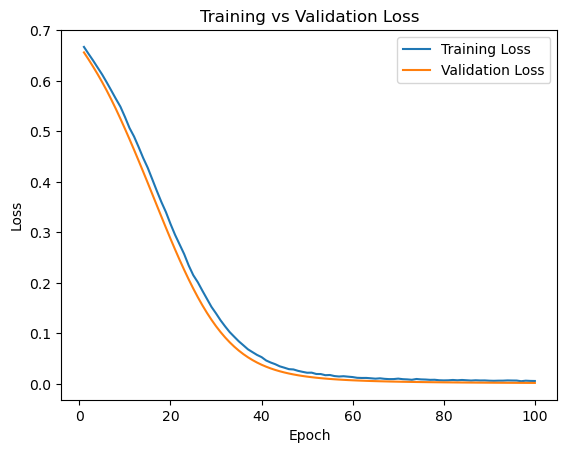

Training Accuracy: 99.97%
Validation Accuracy: 100.00%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import json
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Defining the MLP model class with Dropout for regularization
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(6, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout layer with 30% dropout rate
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout layer with 30% dropout rate
            nn.Linear(64, 12),
            nn.Sigmoid()  # Sigmoid activation to output between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

# Load data from game_log.csv
data = pd.read_csv('game_log.csv', quoting=csv.QUOTE_NONNUMERIC)

# Input feature columns
input_columns = ['P1_Health', 'P1_X', 'P1_Y', 'P2_Health', 'P2_X', 'P2_Y']

# Define button order
button_order = ['Up', 'Down', 'Right', 'Left', 'Select', 'Start', 'Y', 'B', 'X', 'A', 'L', 'R']

# Parse button JSON strings into binary vectors
def parse_buttons(button_str):
    try:
        button_dict = json.loads(button_str)
        return [1 if button_dict.get(button, False) else 0 for button in button_order]
    except json.JSONDecodeError as e:
        print(f"Error parsing button string: {button_str}")
        print(f"Error message: {e}")
        return [0] * len(button_order)

# Apply parsing to P1_Buttons
y = np.array([parse_buttons(button_str) for button_str in data['P1_Buttons']]).astype(np.float32)

# Extract and standardize input features
X = data[input_columns].values.astype(np.float32)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X = torch.tensor(X)
y = torch.tensor(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model, loss, and optimizer
model = MLP()
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Training loop with validation loss tracking
for epoch in range(100):
    model.train()  # Set model to training mode
    optimizer.zero_grad()
    
    # Training step
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    # Validation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    
    # Store losses for later plotting
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Print losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/100], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'mlp_model.pth')
print("\nModel trained and saved as 'mlp_model.pth'.")

# Visualize Class Distribution
button_counts = pd.DataFrame(y_train.numpy(), columns=button_order).sum()
sns.barplot(x=button_counts.index, y=button_counts.values)
plt.title('Distribution of Button Presses in Training Data')
plt.xlabel('Button')
plt.ylabel('Frequency')
plt.show()

# Evaluate the model on the validation set
with torch.no_grad():
    outputs = model(X_val)
    predicted = (outputs > 0.5).float()  # Get predictions (binary classification)
    print("Classification Report:")
    print(classification_report(y_val.numpy(), predicted.numpy(), target_names=button_order))

# Additional Step: Calculate Accuracy
correct = (predicted == y_val).float()
accuracy_per_sample = correct.mean(dim=1)
overall_accuracy = accuracy_per_sample.mean().item()

print(f"\nModel Accuracy (Mean Label-wise Accuracy per Sample): {overall_accuracy * 100:.2f}%")

# Plot the training and validation loss curves
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.plot(range(1, 101), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Print Training vs Validation Accuracy
with torch.no_grad():
    # Training Accuracy
    model.train()
    train_outputs = model(X_train)
    train_predicted = (train_outputs > 0.5).float()
    train_accuracy = (train_predicted == y_train).float().mean()
    
    # Validation Accuracy
    model.eval()
    val_outputs = model(X_val)
    val_predicted = (val_outputs > 0.5).float()
    val_accuracy = (val_predicted == y_val).float().mean()

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')
